# Практическое задание Урока 1

### Тема "Введение, примеры задач, бизнес- и ML-метрики."

### Содержание домашнего задания:
- [Подключение библиотек и скриптов](#python)
- [Задание 1](#task_1)
- [Задание 2](#task_2)
- [Задание 3](#task_3)
- [Задание 4](#task_4)

### Подключение библиотек и скриптов<a class="anchor" id="python"></a>

In [45]:
import numpy as np
import pandas as pd
import math
from sympy import symbols, limit, factorial, cancel, oo, sin, cos, log, ln, latex, diff, sqrt, solve, E, Matrix
from IPython.display import display, Latex
import matplotlib.pyplot as plt

In [46]:
def ShowLatexFormula(x, verbose=False):
    if verbose:
        print(f"ShowLatexFormula: '{x}'")
    display(Latex(r'\begin{eqnarray}' + f"{x}" + r'\end{eqnarray}'))

In [3]:
def hit_rate(recommended_list, bought_list):
    """
    Hit rate@k = (был ли хотя бы 1 релевантный товар среди топ-k рекомендованных)
    """
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(bought_list, recommended_list)
    
    hit_rate = (flags.sum() > 0).astype(int)
    
    return hit_rate

# 
def precision_at_k(recommended_list, bought_list, k=5, verbose=False):
    """
    Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
    Precision - доля релевантных товаров среди рекомендованных = Какой % рекомендованных товаров юзер купил
    """
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    if verbose:
        print(flags)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

def recall_at_k(recommended_list, bought_list, k=5):
    """
    Recall@k = (# of recommended items @k that are relevant) / (# of relevant items)
    Recall - доля рекомендованных товаров среди релевантных = Какой % купленных товаров был среди рекомендованных
    """
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    recall = flags.sum() / len(bought_list)
    
    return recall

def ap_k(recommended_list, bought_list, k=5):
    """
    AP@k - average precision at k
    """
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list, bought_list)
    
    if sum(flags) == 0:
        return 0
    
    sum_ = 0
    for i in range(1, k+1): 
        if flags[i] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i)
            sum_ += p_k
            
    result = sum_ / len(flags)
    
    return result

> ##### NDCG@k - Normalized discounted cumulative gain

> $$DCG = \frac{1}{|r|} \sum_u{\frac{[bought fact]}{discount(i)}}$$  

> $discount(i) = 1$ if $i <= 2$,   
> $discount(i) = log_2(i)$ if $i > 2$
> i - ранк рекомендованного товара  
> |r| - кол-во рекомендованных товаров 

> $$NDCG = \frac{DCG}{ideal DCG}$$

In [49]:
def dcg_k(recommended, bought, k=None, ideal=False):
    """
    DCG@k - Discounted Cumulative Gain at k
    """
    range_ = np.arange(1, k+1)
    if not ideal:
        range_ = range_[np.isin(recommended, bought)[:k]]
    if range_.shape[0] == 0:
        return 0
    return np.vectorize(lambda x: 1.0 if x == 1.0 else 1/np.log(x))(range_).sum()/k

def ndcg_k(recommended, bought, k=None):
    """
    NDCG@k - Normalized Discounted Cumulative Gain at k
    """
    return dcg_k(recommended, bought, k=k, ideal=False)/dcg_k(recommended, bought, k=k, ideal=True)

Проверка:

> $DCG@5 = \frac{1}{5}*(1 / 1 + 0 / log(2) + 0 / log(3) + 1 / log(4) + 0 / log(5))$  
> $ideal DCG@5 = \frac{1}{5}*(1 / 1 + 1 / log(2) + 1 / log(3) + 1 / log(4) + 1 / log(5))$  

In [50]:
dcg_5 = 1/5*(1+1/np.log(4))
idcg_5 = 1/5*(1+1/np.log(2)+1/np.log(3)+1/np.log(4)+1/np.log(5))
dcg_5, idcg_5, dcg_5/idcg_5

(0.34426950408889634, 0.939123344503979, 0.36658603590642364)

In [51]:
recommended_ = np.array([143, 156, 1134, 991, 27, 1543, 3345, 533, 11, 43])
bought_ = np.array([521, 32, 143, 991])

In [52]:
dcg_k(recommended_, bought_, k=5), dcg_k(recommended_, bought_, k=5, ideal=True), \
ndcg_k(recommended_, bought_, k=5)

(0.34426950408889634, 0.9391233445039789, 0.3665860359064237)

$RR@k$ - reciproсal rank для $k$-го объекта
> - Очень простая по своей сути величина, равная *обратному ранку первого правильно угаданного элемента*.

> $ RR@k = \frac{1}{\min\{k\in [1...K] : r^{true}(\pi^{-1}(k))=1\}}, $

In [53]:
def reciprocal_rank_k(recommended_list, bought_list, k=None):
    """
    RR@k - Reciprocal Rank at k
    """
    return 1 / np.arange(1, k+1)[np.isin(recommended, bought)[:k]][0]

> $ R_i = R(g_i) \;\;\;\;\;\;\;\;\;\; (3) $

> $ R(g) = \frac{2^g-1}{2^{g_max}} $, $ g \in \{0, ..., g_{max}\}. \;\;\;\;\;\;\;\;\;\; (4) $

> $ ERR = \sum_{r=1}^{n} \frac{1}{r} P(user \; stops \; at \; position \; r) $

> $ P(user \; stops \; at \; position \; r) = \prod_{i=1}^{r-1} (1-R_i)R_r $

> $ ERR = \sum_{r=1}^{n} \frac{1}{r} \prod_{i=1}^{r-1} (1-R_i)R_r \;\;\;\;\;\;\;\;\;\; (5)$
> - n - number of documents in ranking

```
Algorithm 2: Algorithm to compute the ERR metric (5) in linear time.
---------------------------------------------------------------
Require: Relevance grades g_i, 1 ≤ i ≤ n, and mapping 
    function R such as the one defined in (4).
    p ← 1, ERR ← 0.
    for r = 1 to n do
        R ← R(g_r)
        ERR ← ERR + p · R/r
        p ← p · (1 − R)
    end for
    return ERR
---------------------------------------------------------------
```

In [87]:
def R_g(recommended, i):
    g = np.arange(recommended.shape[0])
    g_i, g_max = g[i-1], g[-1]
    return (2**g_i-1)/(2**g_max)

def err_k(recommended, bought, k=None, verbose=False):
    """
    ERR@k - Expected Reciprocal Rank - Ожидаемый взаимный Ранг
    """
    p, ERR = 1, 0
    for r in range(1, k+1):
        R = R_g(recommended, r)
        ERR_ = ERR
        ERR = ERR + p * R/r
        if verbose:
            print(f"ERR = ERR + p * R/r = {ERR_:.4f} + {p:.4f} * {R:.4f} / {r} = {ERR:.4f}")
        p = p * (1-R)
        if verbose:
            print(f"p = p * (1-R) = {p:.4f} * (1 - {R:.4f}) = {p:.4f}")
    return ERR

<hr>

### Задание 1<a class="anchor" id="task_1"></a>

> **Hit rate** = был ли хотя бы 1 релевантный товар среди рекомендованных
> - Иногда применяется, когда продаются достаточно дрогие товары (например, бытовая техника) 

> **Precision** - доля релевантных товаров среди рекомендованных = Какой % рекомендованных товаров  юзер купил
> - Пожалуй, самая приближенная к бизнес-метрикам и самая популярная метрика
> - Precision= (# of recommended items that are relevant) / (# of recommended items)  
> Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

- Сравните метрики hit_rate@k, precision@k.

In [54]:
recommended_list, bought_list = [5,6,7], [7,8]
hit_rate(recommended_list, bought_list)

1

In [55]:
hit_rate(recommended_list, [6,7])

1

In [56]:
precision_at_k(recommended_list, bought_list, k=2)

0.0

In [57]:
precision_at_k(recommended_list, bought_list, k=3)

0.3333333333333333

In [58]:
precision_at_k(recommended_list, [6,7], k=3)

0.6666666666666666

##### Ответ:
- hit_rate показывает, например сработала или не сработала маркетинговая компания.
- precision_at_k - показывает качество маркетинговой компании или продаж относително топ `K` товаров в списке продвигаемых.

- Какую метрику использовать предпочтительно и почему?

##### Ответ:
- Нет предпочтительной метрики, поскольку все зависит от бизнес условий - примеры:
  - Продали новый самолет да/нет?
  - Или сколько самолетов продали из самых ходовых?

- Приведите пример 2-3 задач (опишите, что является клиентом, что товаром), в которой более уместно использовать метрику hit_rate?

##### Ответ:
- Ответ который был приведен выше - Продали новый самолет да/нет? Товар - самолет, клиент - покупатель.
- "Разводка" (например, 1-апрельская шутка) - товар - fake news, клиент - общественность или мас. медиа.
- Падение крупного метиорита - товар - жизнь на земле, клиент - человеческая расса.

<hr>

### Задание 2<a class="anchor" id="task_2"></a>

- В метрике NDCG@k мы используем логарифм в знаменателе. Как Вы думаете, почему именно логарифм?

##### Ответ:

> **Объяснение из литературы**:

> Использование логарифма как функции дисконтирования можно объяснить следующими интуитивными соображениями: с точки зрения ранжирования позиции в начале списка отличаются гораздо сильнее, чем позиции в его конце. Так, в случае поискового движка между позициями 1 и 11 целая пропасть (лишь в нескольких случаях из ста пользователь заходит дальшей первой страницы поисковой выдачи), а между позициями 101 и 111 особой разницы нет — до них мало кто доходит. Эти субъективные соображения прекрасно выражаются с помощью логарифма:

> $ \frac{1}{log_2 (1+1)} + \frac{1}{log_2 (1+11)} \approx 0.721, а \frac{1}{log_2 (1+101)} + \frac{1}{log_2 (1+111)} \approx 0.003$

- Какую функцию можно использовать вместо логарифма?

##### Ответ:
- Не знаю, в Интернете найти не удалось, возможно $f(x) = 1 - \frac{1}{\sqrt{x}}$.

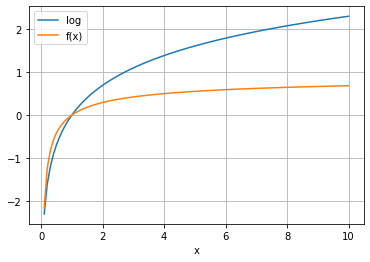

In [34]:
x = np.linspace(0+0.1, 10, 101)
log_ = np.log(x); plt.plot(x, log_, label='log')
f = 1-1/np.sqrt(x); plt.plot(x, f, label='f(x)')
plt.xlabel('x'); plt.grid(True); plt.legend();

- Привидите пример метрик/подходов к предобработке данных/функций ошибок в ML, где также в знаменателе присутствует логарифм.

##### Ответ:
- Где в метриках присутствует `логарифм в знаменателе` пока не знаю, поскольку проходили только где `логарифм в числителе` - например Logloss и энтропийный критерий Шеннона. В Интренете примеры не удалось найти.

<hr>

### Задание 3<a class="anchor" id="task_3"></a>

> Интеракция (англ. interaction, лат. inter - между и actio деятельность) определяется как взаимодействие, взаимное влияние людей или групп друг на друга.

- Какие еще метрики (Вы можете вспомнить уже пройденные Вами или посмотреть в интернете) могут использоваться для рекомендательных систем (приведите примеры метрики и чем являются интеракции, чтобы она могла быть использована).

##### Ответ:
- Пример метрики - кросс-энтропия, пример интеракции - распространение информации (фактов или сплетен/слухов) между группами людей. Применение метрики может, например, помочь выявить групп по интересам.

<hr>

### Задание 4<a class="anchor" id="task_4"></a>
- Посчитайте на этих данных pr@8, rec@8, AP@8, NDCG@8, RR@8, ERR@8 (expected reciprocal rank)  
Сначала поссчитайет "руками", а затем подтвердите рассчеты с помощью функций (некоторые были на семинаре, некоторые нужно будут написать самостоятельно).

In [86]:
k = 8
bought = np.array([1, 3, 5, 7, 9, 11])
recommended = np.array([2, 5, 7, 4, 11, 9, 8, 10, 12, 3])
k, recommended, bought

(8,
 array([ 2,  5,  7,  4, 11,  9,  8, 10, 12,  3]),
 array([ 1,  3,  5,  7,  9, 11]))

#### pr@8
- Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

In [36]:
x = '+'.join([str(x) for x in np.isin(bought, recommended[:k])*1])
ShowLatexFormula('\\frac{'+x+'}{'+str(len(recommended[:k]))+'}'+'='+\
                 str(precision_at_k(recommended, bought, k=k))) #, verbose=True)

<IPython.core.display.Latex object>

#### rec@8
- Recall@k = (# of recommended items @k that are relevant) / (# of relevant items)

In [37]:
x = '+'.join([str(x) for x in np.isin(bought, recommended[:k])*1])
ShowLatexFormula('\\frac{'+x+'}{'+str(len(bought))+'}'+'\\approx'+\
                 str(recall_at_k(recommended, bought, k=k).round(4))) #, verbose=True)

<IPython.core.display.Latex object>

#### AP@8
- AP@k - average precision at k

In [38]:
flags = np.isin(recommended, bought)
precisions = [precision_at_k(recommended, bought, k=i) for i in range(1, k+1) if flags[i]]
x = '+'.join([str(x) for x in precisions])
ShowLatexFormula('\\frac{'+x+'}{'+str(len(recommended))+'}'+ \
                 '='+ str(ap_k(recommended, bought, k=k)))

<IPython.core.display.Latex object>

#### NDCG@8
- NDCG@k - Normalized discounted cumulative gain

In [39]:
range_ = np.arange(1, k+1)[np.isin(recommended, bought)[:k]]
x = '+'.join(['1' if x == 1 else '\\frac{1}{log('+str(x)+')}' for x in range_])
y = '+'.join(['1' if x == 1 else str((1/np.log(x)).round(4)) for x in range_])
ShowLatexFormula('DCG@8 = \\frac{1}{'+str(k)+'} ('+x+')='+'\\frac{1}{'+str(k)+'} ('+y+') \\approx 0.4415')

<IPython.core.display.Latex object>

In [40]:
range_ = np.arange(1, k+1) # [np.isin(recommended, bought)[:k]]
x = '+'.join(['1' if x == 1 else '\\frac{1}{log('+str(x)+')}' for x in range_])
y = '+'.join(['1' if x == 1 else str((1/np.log(x)).round(4)) for x in range_])
ShowLatexFormula('iDCG@8 = \\frac{1}{'+str(k)+'} ('+x+')='+'\\frac{1}{'+str(k)+'} ('+y+') \\approx 0.781')

<IPython.core.display.Latex object>

$ NDCG@8 = 0.4415 \; / \; 0.781 \approx 0.5653 $

In [42]:
dcg_k(recommended, bought, k=k), \
dcg_k(recommended, bought, k=k, ideal=True), \
ndcg_k(recommended, bought, k=k), 0.4415 / 0.781

(0.44154747857833254,
 0.7810655048004851,
 0.5653142737255068,
 0.5653008962868118)

#### RR@8
- RR@k - Reciprocal Rank at k

In [43]:
np.isin(recommended, bought)

array([False,  True,  True, False,  True,  True, False, False, False,
        True])

In [44]:
recommended[np.isin(recommended, bought)][0]

5

$ RR@k = \frac{1}{2} = 0.5 $

In [24]:
reciprocal_rank_k(recommended, bought, k=8)

0.5

#### ERR@8
- ERR@k - Expected Reciprocal Rank - Ожидаемый взаимный Ранг

In [85]:
err_k(recommended, bought, k=8, verbose=True)

ERR = ERR + p * R/r = 0.0000 + 1.0000 * 0.0000 / 1 = 0.0000
p = p * (1-R) = 1.0000 * (1 - 0.0000) = 1.0000
ERR = ERR + p * R/r = 0.0000 + 1.0000 * 0.0020 / 2 = 0.0010
p = p * (1-R) = 0.9980 * (1 - 0.0020) = 0.9980
ERR = ERR + p * R/r = 0.0010 + 0.9980 * 0.0059 / 3 = 0.0029
p = p * (1-R) = 0.9922 * (1 - 0.0059) = 0.9922
ERR = ERR + p * R/r = 0.0029 + 0.9922 * 0.0137 / 4 = 0.0063
p = p * (1-R) = 0.9786 * (1 - 0.0137) = 0.9786
ERR = ERR + p * R/r = 0.0063 + 0.9786 * 0.0293 / 5 = 0.0121
p = p * (1-R) = 0.9500 * (1 - 0.0293) = 0.9500
ERR = ERR + p * R/r = 0.0121 + 0.9500 * 0.0605 / 6 = 0.0216
p = p * (1-R) = 0.8924 * (1 - 0.0605) = 0.8924
ERR = ERR + p * R/r = 0.0216 + 0.8924 * 0.1230 / 7 = 0.0373
p = p * (1-R) = 0.7826 * (1 - 0.1230) = 0.7826
ERR = ERR + p * R/r = 0.0373 + 0.7826 * 0.2480 / 8 = 0.0616
p = p * (1-R) = 0.5885 * (1 - 0.2480) = 0.5885


0.061591297872009065

<hr>

### Ссылки:
- Рекомендательные системы: идеи, подходы, задачи https://habr.com/ru/company/jetinfosystems/blog/453792/
- Анатомия рекомендательных систем. Часть первая (постановка, подготовка данных) https://habr.com/ru/company/lanit/blog/420499/
- Анатомия рекомендательных систем. Часть вторая (метрики, бейзлайн подходы) https://habr.com/ru/company/lanit/blog/421401/
- Метрики качества ранжирования https://habr.com/ru/company/econtenta/blog/303458/
- Метрики качества ранжирования https://gist.github.com/Obus/697ef8f6af97f7aac9351f1ea5f94d6a
- Функционалы качества бинарной классификации (обзор Дьяконова) https://dyakonov.org/2019/05/31/функционалы-качества-в-задаче-бинарн
- Метрики ранжирования (курс Дьяконова) https://github.com/Dyakonov/PZAD/blob/master/2020/PZAD2020_034err_multirankcluster_03.pdf

<hr>

- Discounted cumulative gain https://en.wikipedia.org/wiki/Discounted_cumulative_gain
- Discounted Cumulative Gain https://machinelearningmedium.com/2017/07/24/discounted-cumulative-gain/
- Normalized Discounted Cumulative Gain https://towardsdatascience.com/normalized-discounted-cumulative-gain-37e6f75090e9
- Discounted cumulative gain https://www.wikiwand.com/en/Discounted_cumulative_gain
- Evaluate your Recommendation Engine using NDCG https://towardsdatascience.com/evaluate-your-recommendation-engine-using-ndcg-759a851452d1
- Интеракция https://communication_psychology.academic.ru/251/Интеракция
- mblondel/letor_metrics.py https://gist.github.com/mblondel/7337391
- sklearn.metrics.dcg_score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.dcg_score.html
- sklearn.metrics.ndcg_score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html
- Normalized Discounted Cumulative Gain https://scikit-learn.org/stable/modules/model_evaluation.html#normalized-discounted-cumulative-gain
- Обучение ранжированию https://ru.wikipedia.org/wiki/Обучение_ранжированию Learning to rank https://en.wikipedia.org/wiki/Learning_to_rank
- Expected Reciprocal Rank for Graded Relevance https://web.archive.org/web/20200426192936/http://www.olivier.chapelle.cc/pub/err.pdf
- IREEL: Information Retrieval (IR) Effectiveness Evaluation Library for Python https://github.com/ozcan39/ir_evaluation_py
- Support ERR (expected reciprocal rank) metric #16813 https://github.com/scikit-learn/scikit-learn/issues/16813
- Demystifying nDCG and ERR https://opensourceconnections.com/blog/2019/12/09/demystifying-ndcg-and-err/
- https://github.com/skondo/evaluation_measures/blob/master/evaluations_measures.py

##### Примечание:
- Не удалост разобраться как метрики dcg_score и ndcg_score из sklearn.metrics соотносятся с DCG@K и NDCG@K.
- Просьба объяснить при разборе домашнего задания.

In [25]:
from sklearn.metrics import dcg_score, ndcg_score

In [26]:
# we have groud-truth relevance of some answers to a query:
true_relevance = np.asarray([[10, 0, 0, 1, 5]])
# we predict scores for the answers
scores = np.asarray([[.1, .2, .3, 4, 70]])
dcg_score(true_relevance, scores)

9.499457825916874

In [27]:
true_relevance = np.array([10, 0, 0, 1, 5])
scores = np.array([.1, .2, .3, 4, 70])
dcg_score(true_relevance[None,:], scores[None,:])

9.499457825916874

In [28]:
dcg_score(true_relevance[None,:], scores[None,:], k=2)

5.630929753571458

In [29]:
scores = np.array([1, 0, 0, 0, 1])
# by default ties are averaged, so here we get the average true
# relevance of our top predictions: (10 + 5) / 2 = 7.5
dcg_score(true_relevance[None,:], scores[None,:], k=1)

7.5

In [30]:
# we can choose to ignore ties for faster results, but only
# if we know there aren't ties in our scores, otherwise we get
# wrong results:
dcg_score(true_relevance[None,:], scores[None,:], k=1, ignore_ties=True)

5.0

In [31]:
true_relevance_ = np.vectorize(lambda x: 1.0 if x == 1.0 else 1/np.log(x))(np.arange(1, recommended_.shape[0]+1, 1))
true_relevance_

array([1.        , 1.44269504, 0.91023923, 0.72134752, 0.62133493,
       0.55811063, 0.51389834, 0.48089835, 0.45511961, 0.43429448])

In [32]:
scores_ = np.isin(recommended_, bought_)*1.0
scores_

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [33]:
dcg_score(true_relevance_[None,:], scores_[None,:], k=5)/5

0.4591526185507053